In [1]:
import json
with open("config.json") as json_file:
    parameter = json.load(json_file)

# Load dataset

In [2]:
import numpy as np
import pickle


with open(parameter["SAVE_DIR"]+"TCC_matrix.dat", 'rb') as f:
    T=pickle.load(f)
with open(parameter["SAVE_DIR"]+"pwise_dist_L1.dat", 'rb') as f:
    D_l1=pickle.load(f)
with open(parameter["SAVE_DIR"]+"nonzero_ec.dat", 'rb') as f:
    nonzero_ec=pickle.load(f)

ecfile_dir = parameter["kallisto"]["TCC_output"]+'/matrix.ec'
eclist=np.loadtxt(ecfile_dir,dtype=str)    

from sklearn.preprocessing import normalize

T_norm = normalize(T, norm='l1', axis=0) 
T_normT = T_norm.transpose()
    
NUM_OF_CELLS=np.shape(T)[1]
print "NUM_OF_CELLS =", NUM_OF_CELLS
print "NUM_OF_nonzero_EC =", np.shape(T)[0]

NUM_OF_CELLS = 1298
NUM_OF_nonzero_EC = 15331


In [3]:
EC_dict = {}
for i in range(np.shape(eclist)[0]):
    EC_dict[i] = [int(x) for x in eclist[i,1].split(',')]
    
union=set()
for i in nonzero_ec:
    new = [tx for tx in EC_dict[i] if tx not in union] # filter out previously seen transcripts
    union.update(new) 
union_list=list(union) #union of all transctipt ids seen in nonzero eq.classes
NUM_OF_TX_inTCC = len(union)
print "NUM_OF_Transcripts =", NUM_OF_TX_inTCC #number of distinct transcripts in nonzero eq. classes 

NUM_OF_Transcripts = 34354


### Inspect

In [4]:
#sort eq. classes based on size
size_of_ec = [len(EC_dict[i]) for i in nonzero_ec]
ec_idx = [i[0] for i in sorted(enumerate(size_of_ec), key=lambda x:x[1])]
index_ec = np.array(ec_idx)

ec_sort_map={}
nonzero_ec_srt=[]; #init
for i in range(len(nonzero_ec)):
    nonzero_ec_srt+=[nonzero_ec[index_ec[i]]]
    ec_sort_map[nonzero_ec[index_ec[i]]] = i
nonzero_ec_srt = np.array(nonzero_ec_srt)

ec_size_sort=np.array(size_of_ec)[index_ec]
sumi = np.array(T.sum(axis=1))
sumi_sorted=sumi[index_ec]
total_num_of_umis = int(sumi_sorted.sum())
total_num_of_umis_per_cell = np.array(T.sum(axis=0))[0,:]

print "Total number of UMIs =", total_num_of_umis

Total number of UMIs = 57474


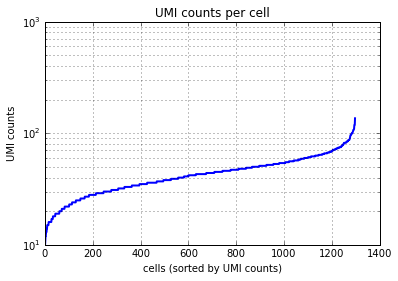

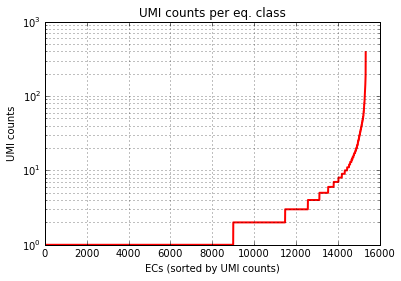

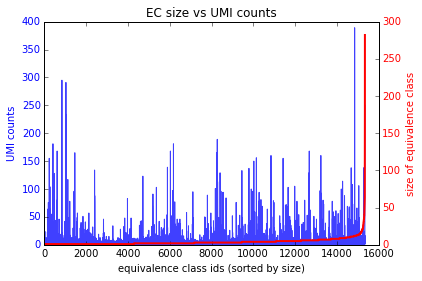

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.plot(sorted(total_num_of_umis_per_cell), 'b-',linewidth=2.0)
ax1.set_title('UMI counts per cell')
ax1.set_xlabel('cells (sorted by UMI counts)')
ax1.set_ylabel('UMI counts')
ax1.set_yscale("log", nonposy='clip')
# ax1.set_xscale("log", nonposy='clip')
ax1.grid(True)
ax1.grid(True,'minor')


fig, ax1 = plt.subplots()
ax1.plot(sorted(sumi.reshape(np.shape(sumi)[0])), 'r-',linewidth=2.0)
ax1.set_title('UMI counts per eq. class')
ax1.set_xlabel('ECs (sorted by UMI counts)')
ax1.set_ylabel('UMI counts')
ax1.set_yscale("log", nonposy='clip')
# ax1.set_xscale("log", nonposy='clip')
ax1.grid(True)
ax1.grid(True,'minor')


fig, ax1 = plt.subplots()
ax1.plot(sumi_sorted, 'b-', alpha=0.75)
ax1.set_title('EC size vs UMI counts')
ax1.set_xlabel('equivalence class ids (sorted by size)')
ax1.set_ylabel('UMI counts', color='b')
# ax1.set_xlim([0,620000])
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()

ax2.plot(ec_size_sort, 'r',linewidth=2.0)
ax2.set_ylabel('size of equivalence class', color='r')
# ax2.set_xlim([0,620000])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

# Clustering

In [6]:
from sklearn import cluster,manifold
import matplotlib.pyplot as plt
%matplotlib inline

def AffinityProp(D,pref,damp):
    aff= cluster.AffinityPropagation(affinity='precomputed',
                                     preference=pref,damping=damp, verbose=True)
    labels=aff.fit_predict(D)
    return labels

def spectral(k,D):
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels

def tSNE_pairwise(D):
    tsne = manifold.TSNE(n_components=2, random_state=213, metric='precomputed', n_iter=2000, verbose=1);
    X_tsne = tsne.fit_transform(D);
    return X_tsne

#### t-SNE

In [7]:
X_tsne=tSNE_pairwise(D_l1)

[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.153036
[t-SNE] Error after 65 iterations with early exaggeration: 21.238478
[t-SNE] Error after 143 iterations: 2.444567


In [8]:
# Plot function with (nonrandom) colors corresponding to labels (star a specific label)
def stain_plot(X,labels,stain,title,nc=2):
    unique_labels = np.unique(labels)
    N = len(unique_labels)
    max_value = 16581375 #255**3
    interval = int(max_value / N)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]    
    color= [(int(i[:2], 16)/float(255), int(i[2:4], 16)/float(255), 
             int(i[4:], 16)/float(255)) for i in colors]
    i=0;
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        if label in stain: 
            plt.scatter(X[ind,0],X[ind,1],c='red',s=146,edgecolor='black',
                        lw = 0.5, alpha=1,marker='*',label=label)
        else:
            plt.scatter(X[ind,0],X[ind,1],c=color[i],s=36,edgecolor='lightgray',
                        lw = 0.5,label=label)        
        i+=1   
    plt.title(title)
    plt.legend(loc='upper right',bbox_to_anchor=(1.18, 1.01),ncol=nc)
#     plt.xlim([-20,20])  
#     plt.ylim([-20,20])  
    plt.axis('off')

#### Spectral Clustering

In [9]:
num_of_clusters=2
similarity_mat=D_l1.max()-D_l1
labels_spectral = spectral(num_of_clusters,similarity_mat)

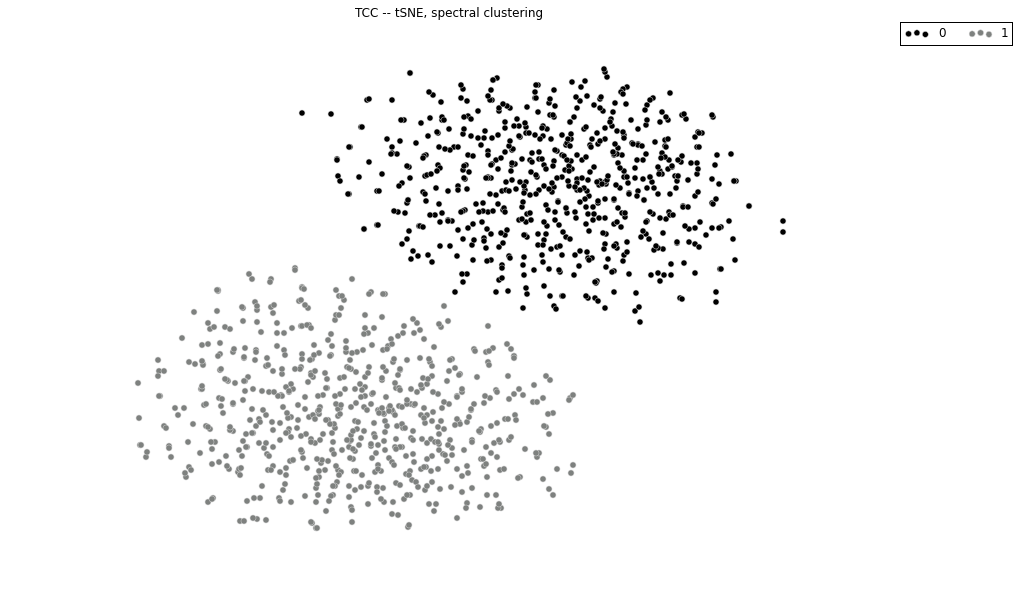

In [11]:
stain_plot(X_tsne,labels_spectral,[],"TCC -- tSNE, spectral clustering")

#### Affinity Propagation

In [ ]:
pref = -np.median(D_l1)*np.ones(NUM_OF_CELLS)
labels_aff=AffinityProp(-D_l1,pref,0.5)
np.unique(labels_aff)

In [ ]:
stain_plot(X_tsne,labels_aff,[],"TCC -- tSNE, affinity propagation")

#### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(T_normT.todense())

In [ ]:
stain_plot(X_pca,labels_aff,[],"TCC -- PCA, affinity propagation")